In [2]:
# 기초 전처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

# 캔버스 사이즈 적용
plt.rcParams['figure.figsize'] = (12, 9)

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

# pandas 결과값의 표현 범위 소수점 2자리수로 변경
pd.options.display.float_format = '{:.2f}'.format

# 파일 로드위한 directory 확인 및 현재 경로로 설정
a = os.getcwd()
os.chdir(a)

# 0. 데이터 불러오기

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv') 

print('Data Loading is Done!')

Data Loading is Done!


# 1. EDA & Preprocessing

## Feature Engineering

In [4]:
# 현재 train & test 데이터의 형태 확인
print("The shape of Train Data is:", train.shape, "\n")
print("The shape of Test Data is:", test.shape)

The shape of Train Data is: (1460, 81) 

The shape of Test Data is: (1459, 80)


In [5]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

데이터에 결측치가 있는 것이 발견된다. 피처 엔지니어링을 통해 해당 변수들을 전처리할 필요가 있다.

## 이상치 제거

- 수치형 데이터에서 가장 빈번하게 나타난다.
    - 예측 범위가 넓은 데이터(e.g: 가격)은 데이터의 범위가 클 수록 예측 정확도가 떨어지기 때문에 이상치 확인은 중요하다.
- 이상치 제거의 기준을 단순히 숫자로만 판단하면 안된다.
    - '이상치 = 적절하지 않게 측정된 데이터' 라는 개념으로 인지하는게 중요.

> e.g) 
- OverallQual: Rates the overall material and finish of the house

- OverallCond: Rates the overall condition of the house

와 같은 데이터는 설문 조사자의 주관적 편향이 들어갈 우려가 있는 객관적이지 못한 데이터 이다.
이러한 데이터 또한 이상치로 간주할 수 있을 것이다.

In [7]:
def jointplots(xs, y, data, hue=None, height=6, ratio=5, space=0.2, xlabels=None, ylabel=None, margin_norm=False):
    """
    -------------------
    Input Parameters
    -------------------
    xs      : (list or str) feature name(s) of data
    y       : (str) feature name of data
    data    : (pandas.DataFrame)
    hue     : (str) semantic variable that is mapped to determine the color of plot elements. Semantic variable that is mapped to determine the color of plot elements.
    
    height  : (float) size of the figure
    ratio   : (float) ratio of the joint axes height to marginal axes height.
    space   : (float) space between the joint and marginal axes
    
    xlabels : (list or str) xlabels
    ylabel  : (str) ylabel
    margin_norm : (boolean) if True, kdeplots at marginal axes have same scale.
    """
    ### 1. input check
    # input type
    assert isinstance(xs, list) or isinstance(xs, str)
    if isinstance(xs, list):
        assert all([isinstance(x, str) for x in xs])
    else:
        xs = [xs]
        
    
    if xlabels != None:
        assert isinstance(xlabels, list) or isinstance(xlabels, str)
        if isinstance(xlabels, list):
            assert all([isinstance(xlabel, str) for xlabel in xlabels])
        else:
            xlabels = [xlabels]
    
    if ylabel != None:
        assert isinstance(ylabel, str)
    
    if hue != None:
        assert isinstance(hue, str)
    
    # input data
    assert all([x in data.columns for x in xs])
    assert y in data.columns
    if hue != None:
        assert hue in data.columns
    
    
    ### 2. figure
    h_margin = height / (ratio + 1)
    h_joint = height - h_margin
    
    if isinstance(xs, list):
        n_x = len(xs)
    else:
        n_x = 1
    
    widths = [h_joint] * n_x + [h_margin]
    heights = [h_margin, h_joint]
    ncols = len(widths)
    nrows = len(heights)
    
    fig = plt.figure(figsize=(sum(widths), sum(heights)))
    
    ### 3. gridspec preparation
    spec = fig.add_gridspec(ncols=ncols, nrows=nrows, 
                            width_ratios = widths, height_ratios = heights,
                            wspace=space, hspace=space
                           )
    
    ### 4. setting axes
    axs = {}
    for i in range(ncols * nrows):
        axs[i] = fig.add_subplot(spec[i//ncols, i%ncols])
    
    
    ### 5. jointplots (scatterplot + kdeplot)
    for i, x in enumerate(xs, ncols):
        if i == ncols:
            legend=True
        else:
            legend=False
        sns.kdeplot(x=x, y=y, data=data, hue=hue, alpha=0.3, ax=axs[i], zorder=2, legend=False)
        sns.scatterplot(x=x, y=y, data=data, hue=hue, alpha=0.8, ax=axs[i], zorder=3, legend=legend)
    
    
    ### 6. kdeplots at marginal axes
    axs[ncols-1].axis("off")
    
    axes_mx = list(range(ncols-1))
    axes_my = 2*ncols - 1
    
    for i, x in zip(axes_mx, xs):
        sns.kdeplot(x=x, data=data, hue=hue, fill=True, ax=axs[i], zorder=2, legend=False)
        axs[i].set_xlim(axs[i+ncols].get_xlim())
        axs[i].set_xlabel("")
        axs[i].set_xticklabels([])
        axs[i].spines["left"].set_visible(False)
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
    
    sns.kdeplot(y=y, data=data, hue=hue, fill=True, ax=axs[axes_my], zorder=2, legend=False)
    axs[axes_my].set_ylim(axs[ncols].get_ylim())
    axs[axes_my].set_ylabel("")
    axs[axes_my].set_yticklabels([])
    axs[axes_my].spines["bottom"].set_visible(False)
    axs[axes_my].spines["top"].set_visible(False)
    axs[axes_my].spines["right"].set_visible(False)
    
    if margin_norm == True:
        hist_range_max = max([axs[m].get_ylim()[-1] for m in axes_mx] + [axs[axes_my].get_xlim()[-1]])
        for i in axes_mx:
            axs[i].set_ylim(0, hist_range_max)
        axs[axes_my].set_xlim(0, hist_range_max)
        
        
    ### 7. unnecessary elements removal
    # 7.1. labels and ticklabels
    axes_j = list(range(ncols, 2*ncols-1))
    for i in axes_j:
        if i != ncols:
            axs[i].set_ylabel("")
            axs[i].set_yticklabels([])
    
    # 7.2. marginal axes
    for i in axes_mx:
        if i != 0:
            axs[i].set_ylabel("")
        
        axs[i].grid("on", color="lightgray", zorder=0)
        axs[i].set_yticklabels([])
        
        yticks = axs[i].get_yticks()
        ylim = axs[i].get_ylim()
        for ytick in yticks:
            if 0 < ytick < ylim[-1]:
                axs[i].text(axs[i].get_xlim()[0], ytick, str(ytick), 
                            fontdict={"verticalalignment":"center"})
        
    axs[axes_my].grid("on", color="lightgray", zorder=0)
    axs[axes_my].set_xticklabels([])
    axes_my_xticks = axs[axes_my].get_xticks()
    axes_my_xlim = axs[axes_my].get_xlim()
    for xtick in axes_my_xticks:
        if 0 < xtick < axes_my_xlim[-1]:
            axs[axes_my].text(xtick, axs[axes_my].get_ylim()[0], str(xtick), 
                              rotation=270, fontdict={"horizontalalignment":"center"})
    
    # 7.3. labels
    font_label = {"color": "gray", "fontsize":"large"}
    labelpad = 12
    for i, x in zip(axes_j, xlabels):
        axs[i].set_xlabel(x, fontdict=font_label, labelpad=labelpad)
        if i == ncols:
            axs[i].set_ylabel(ylabel, fontdict=font_label, labelpad=labelpad)
    
    axs[0].set_ylabel("Density", fontdict=font_label, labelpad=labelpad)
    axs[2*ncols-1].set_xlabel("Density", fontdict=font_label, labelpad=labelpad)
    
    fig.align_ylabels([axs[0], axs[ncols]])
    fig.align_xlabels([axs[x] for x in range(ncols, 2*ncols)])
    plt.tight_layout()
    
    return fig, axs

(<Figure size 1056x576 with 6 Axes>,
 {0: <AxesSubplot:ylabel='Density'>,
  1: <AxesSubplot:>,
  2: <AxesSubplot:>,
  3: <AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>,
  4: <AxesSubplot:xlabel='OverallCond'>,
  5: <AxesSubplot:xlabel='Density'>})

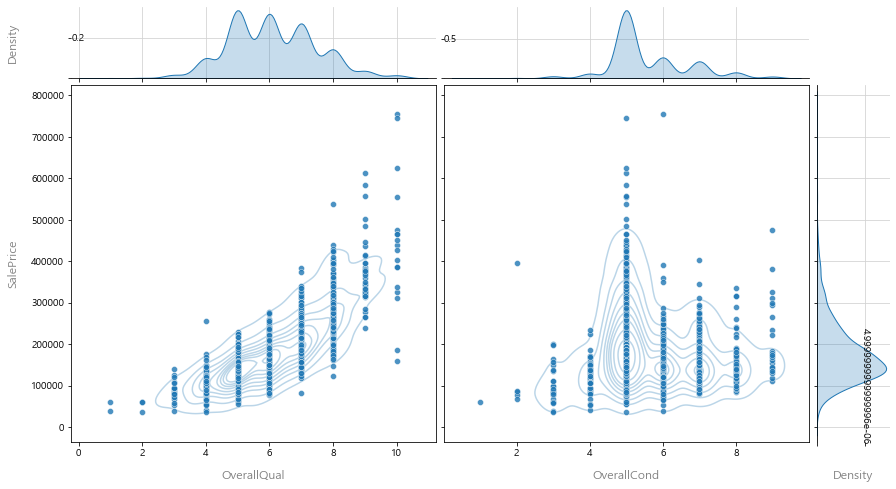

In [8]:
jointplots(["OverallQual", "OverallCond"], "SalePrice", train, height=8, ratio= 5, space=0.03,
          xlabels = ["OverallQual", "OverallCond"], ylabel="SalePrice")

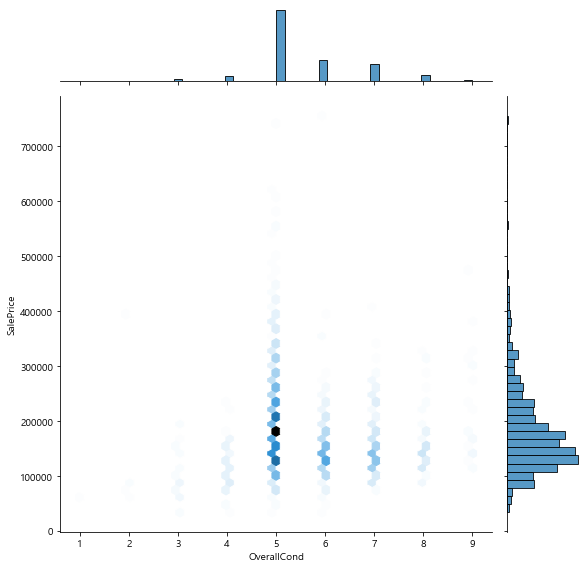

In [49]:
sns.jointplot(x="OverallCond", y="SalePrice", height=8, data=train, kind="hex")
plt.show()

- OverallQual, OverallCond 데이터의 대부분은 4 이상인 값들이 대부분이다.
- 대부분의 가격은 100000 ~ 200000 사이에 형성되어 있다.
- 두 조건을 감안해 

In [22]:
# OverallQual , OverallCond 데이터중 이상치 제거
# 시각화 결과와 같이 대부부분의 SalePrice 데이터는 
OverallQual 의 경우 대부분의 데이터가 4

# OverallQual rate값이 4이하이면서 SalePrice가 200000 이상인 데이터 제거
train.drop( train[(train['OverallQual']<4 ) & ( train['SalePrice']>200000) ].index, inplace=True)
           
# OverallCond rate값이 4이하이면서 SalePrice가 200000 이상인 데이터 제거
train.drop( train[(train['OverallCond']<4 ) & ( train['SalePrice']>200000) ].index, inplace=True)
           
train.reset_index(drop=True, inplace=True)
           
#결과 확인
# 기존 train shape 결과 : The shape of Train Data is: (1460, 81) 
print(train.shape) 

(1458, 81)


## 종속 변수(SalePrice)의 로그화

### SalePrice 시각화

In [9]:
from scipy.stats import norm

The value of mu before log transformation is: 180761.24142661178 

The value of sigma after log transformation is: 79270.93617295024


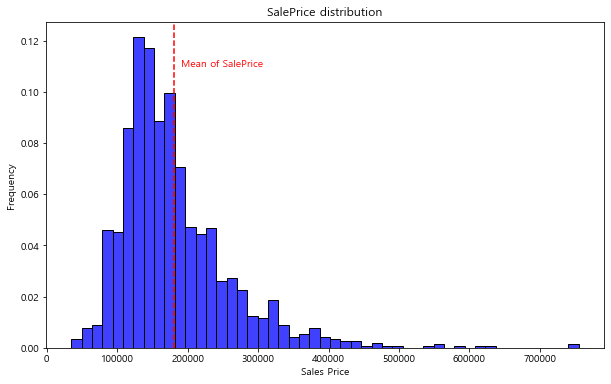

In [10]:
(mu, sigma) = norm.fit(train['SalePrice'])
print("The value of mu before log transformation is:" , mu, "\n")
print("The value of sigma after log transformation is:" , sigma)

# 캔버스 세팅
fig, ax = plt.subplots(figsize=(10,6))

# Histogram 데이터 입력
sns.histplot(train['SalePrice'], color ='b', stat='probability')

# 축 설정
ax.xaxis.grid(False) 
ax.set(ylabel = 'Frequency')
ax.set(xlabel = 'Sales Price')
ax.set(title = 'SalePrice distribution')

# 가격 평균선 입력
plt.axvline(mu, color='r', linestyle = '--')

# 가격 평균선 text 설정
plt.text(mu+10000, 0.11, 'Mean of SalePrice', rotation = 0, color = 'r')

fig.show()

- 주택 가격이 정규분포 형태를 이루지 않고 있다.
- 일반적인 선형 회귀는 각 데이터가 '정규분포를 만족한다' 를 전제로 한다.
- 따라서 해당 데이터를 np.log1p() 를 활용해 SalePrice를 로그화 한다.

The value of mu before log transformation is: 12.0233397799989 

The value of sigma after log transformation is: 0.3989191793099824


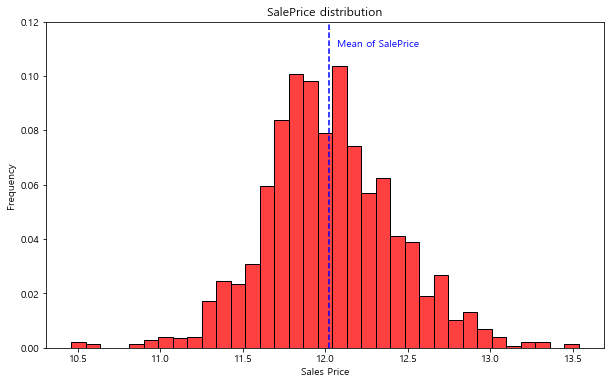

In [11]:
# SalePrice 로그화
train['SalePrice'] = np.log1p(train['SalePrice'])

(mu, sigma) = norm.fit(train['SalePrice'])
print("The value of mu before log transformation is:" , mu, "\n")
print("The value of sigma after log transformation is:" , sigma)

# 캔버스 세팅
fig, ax = plt.subplots(figsize=(10,6))

# Histogram 데이터 입력
sns.histplot(train['SalePrice'], color ='r', stat='probability')

# 축 설정
ax.xaxis.grid(False) 
ax.set(ylabel = 'Frequency')
ax.set(xlabel = 'Sales Price')
ax.set(title = 'SalePrice distribution')

# 가격 평균선 입력
plt.axvline(mu, color='b', linestyle = '--')

# 가격 평균선 text 설정
plt.text(mu+0.05, 0.111, 'Mean of SalePrice', rotation = 0, color = 'b')
plt.ylim(0, 0.12)

fig.show()

## 데이터 합치기 (Train + Test)

In [12]:
# 입력변수 = 각 컬럼의 ID는 별도 저장
train_ID = train['Id']
test_ID = test['Id']

# ID 제외 나머지 컬럼만 데이터에 남김
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

# 결과 확인
print("The shape of Train Data is:", train.shape, "\n")
print("The shape of Test Data is:", test.shape)

The shape of Train Data is: (1458, 80) 

The shape of Test Data is: (1459, 79)


In [13]:
# SalePrice 별도 추출 및 저장

y = train['SalePrice'].reset_index(drop = True)
train = train.drop('SalePrice', axis = 1)

# 결과 확인
print("The shape of Train Data is:", train.shape, "\n")
print("The shape of Test Data is:", test.shape, "\n")
print("The shape of y label is:", y.shape)

The shape of Train Data is: (1458, 79) 

The shape of Test Data is: (1459, 79) 

The shape of y label is: (1458,)


변수의 개수가 모두 동일하게 되어 두 데이터를 합칠 수 있다.

In [14]:
all_df = pd.concat([train, test]).reset_index(drop=True)
print("The shape of 'all_data' is:", all_df.shape )

The shape of 'all_data' is: (2917, 79)


### 결측치 처리

- 결측치 : 중간에 데이터 값이 비어 있는 경우.

#### 결측치 확인

In [15]:
# head_num : 결과 출력할때 haed()의 수

# df의 null값 비율 체크해서 비율로 변환 & 내림차순 정렬 함수
def check_na(data, head_num):
    """결측치 확인하여 비율로 변환"""
    isnull_ratio = (data.isnull().sum() / len(data)) * 100 
    data_na = isnull_ratio.drop(isnull_ratio[isnull_ratio == 0].index).sort_values(ascending = False)
    missing_data = pd.DataFrame({'Missing Ratio' : data_na,
                                    'Data Type' : data.dtypes[data_na.index]})
    print("결측치 데이터 컬럼 및 건수 : \n", missing_data.head(head_num))

In [16]:
# 결측치 확인
check_na(all_df, 20)

결측치 데이터 컬럼 및 건수 : 
               Missing Ratio Data Type
PoolQC                99.66    object
MiscFeature           96.40    object
Alley                 93.21    object
Fence                 80.43    object
FireplaceQu           48.68    object
LotFrontage           16.63   float64
GarageFinish           5.45    object
GarageQual             5.45    object
GarageCond             5.45    object
GarageYrBlt            5.45   float64
GarageType             5.38    object
BsmtExposure           2.81    object
BsmtCond               2.81    object
BsmtQual               2.78    object
BsmtFinType2           2.74    object
BsmtFinType1           2.71    object
MasVnrType             0.79    object
MasVnrArea             0.75   float64
MSZoning               0.14    object
BsmtFullBath           0.07   float64


In [17]:
# 결측치 비율이 평균 이상인 컬럼 (PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage) 제거

all_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], axis = 1, inplace = True)
check_na(all_df, 20)

결측치 데이터 컬럼 및 건수 : 
               Missing Ratio Data Type
GarageCond             5.45    object
GarageQual             5.45    object
GarageYrBlt            5.45   float64
GarageFinish           5.45    object
GarageType             5.38    object
BsmtCond               2.81    object
BsmtExposure           2.81    object
BsmtQual               2.78    object
BsmtFinType2           2.74    object
BsmtFinType1           2.71    object
MasVnrType             0.79    object
MasVnrArea             0.75   float64
MSZoning               0.14    object
Functional             0.07    object
Utilities              0.07    object
BsmtFullBath           0.07   float64
BsmtHalfBath           0.07   float64
GarageArea             0.03   float64
GarageCars             0.03   float64
TotalBsmtSF            0.03   float64


#### 문자열 결측치 처리

1) 방법 1. 각 변수를 확인해 개별적으로 필요 데이터를 채워넣는 방식
- 문자열 결측치 : 빈도수 위주로 채워넣기 (출현 빈도가 가장 높은 문자열로 일괄 처리)
- 수치 데이터 결측치 : 평균(mean) or 중간값(median) 으로 채워넣기

2) 방법 2. 일괄적으로 0 or None 값을 채워넣기
- fillna() 함수로 일괄처리 가능

방법 1 사용 - 문자열 데이터 최빈값으로 채워넣기

In [18]:
# train에서 dtype이 object인 변수명 별도 추출
cat_all_vars = train.select_dtypes(exclude = [np.number])
print("The whole number of all_vars", len(list(cat_all_vars)),'\n')


# 기존에 결측치 문제로 제거한 변수를 제외한 다른 변수들에 적용하기 위해 제거된 변수들을 제외
# 기존에 제거한 변수들 중 object 형태의 변수들만 범위로 지정
final_cat_vars = []
for v in cat_all_vars: # train의 모든 object 변수들중에
    if v not in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']: # drop한 변수외의 변수들을
        final_cat_vars.append(v)  # final_cat_vars에 append하기
print("The whole number of final_cat_vars", len(list(final_cat_vars)),'\n')

# 각 변수별로 최빈값(최빈단어)로 fillna
for i in final_cat_vars:
    all_df[i] = all_df[i].fillna(i).mode()[0]
    
print(check_na(all_df,15)) # float에만 null값이 남아있고, 모든 object에서의 null값은 대체되었다.

The whole number of all_vars 43 

The whole number of final_cat_vars 38 

결측치 데이터 컬럼 및 건수 : 
               Missing Ratio Data Type
GarageYrBlt            5.45   float64
MasVnrArea             0.75   float64
BsmtFullBath           0.07   float64
BsmtHalfBath           0.07   float64
BsmtFinSF1             0.03   float64
BsmtFinSF2             0.03   float64
BsmtUnfSF              0.03   float64
TotalBsmtSF            0.03   float64
GarageCars             0.03   float64
GarageArea             0.03   float64
None


방법 1 사용 - 수치형데이터 (median 으로 채워넣기)

In [19]:

# train 에서 숫자형 변수의 리스트 생성
num_all_vars = list(train.select_dtypes(include=[np.number]))
print("The whole number of all_vars", len(list(num_all_vars)),'\n')

# 결측치 비율 기준 제거한 숫자형 변수는 1개
# 간단하게 remove() 를 써서 drop
num_all_vars.remove('LotFrontage')

# 수치형 변수들의 중앙값(median)으로 결측치 채워넣기
print("The whole number of final_cat_vars", len(list(num_all_vars)),'\n')
for i in num_all_vars:
    all_df[i].fillna(value = all_df[i].median(), inplace = True)
    
# 최종 결과 확인
check_na(all_df,10) 

# 모든 결측치 사라진 것 확인

The whole number of all_vars 36 

The whole number of final_cat_vars 35 

결측치 데이터 컬럼 및 건수 : 
 Empty DataFrame
Columns: [Missing Ratio, Data Type]
Index: []


### 왜도(skewness)값 처리

- 분포의 비대칭도를 나타내는 통계량 (자료의 대칭성을 확인하는 측도의 한 종류)
- 정규 분포와 같이 대칭인 분포는 왜도값이 0이다.
- 수치형 데이터에 적용가능하며, 예측 변수 활용할때 왜도의 보정은 매우 중요하다.
- 왜도 문제를 해결한 데이터일때 예측 모델의 신뢰도를 더 높일 수 있기 때문이다.

---
![image](https://user-images.githubusercontent.com/74717033/132131943-f7a6e177-1d10-4a15-89d1-e655ab8fbf04.png)
[Resource: 밥먹는 개발자](https://dining-developer.tistory.com/17)

In [20]:
from scipy.stats import skew

# 수치형 데이터 왜도 구하는 함수 생성
def find_skew(x):
    return skew(x)

# 수치형 변수 왜도를 구하고 내림차순으로 정렬
skew_features = all_df[num_all_vars].apply(find_skew).sort_values(ascending = False)
skew_features

MiscVal         21.94
PoolArea        16.89
LotArea         12.87
LowQualFinSF    12.08
3SsnPorch       11.37
KitchenAbvGr     4.32
BsmtFinSF2       4.14
EnclosedPorch    4.01
ScreenPorch      3.95
BsmtHalfBath     3.93
MasVnrArea       2.62
OpenPorchSF      2.53
WoodDeckSF       1.84
1stFlrSF         1.47
BsmtFinSF1       1.43
MSSubClass       1.37
GrLivArea        1.27
TotalBsmtSF      1.17
BsmtUnfSF        0.92
2ndFlrSF         0.86
TotRmsAbvGrd     0.76
Fireplaces       0.73
HalfBath         0.70
BsmtFullBath     0.63
OverallCond      0.58
BedroomAbvGr     0.33
GarageArea       0.24
OverallQual      0.20
MoSold           0.20
FullBath         0.16
YrSold           0.13
GarageCars      -0.22
GarageYrBlt     -0.40
YearRemodAdd    -0.45
YearBuilt       -0.60
dtype: float64

#### 왜도 시각화 : before Box-Cox Transformation 

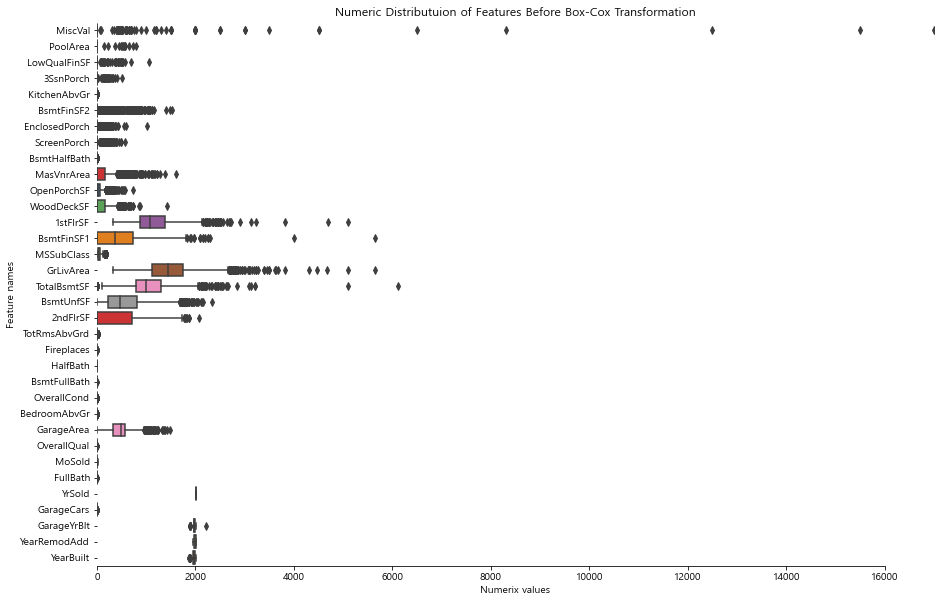

In [21]:
# 왜도인 변수의 index get
skewness_index = list(skew_features.index)

# LotArea의 수치가 너무 커서 다른 변수들의 비대칭 분포를 확인하기 어려워 제외
skewness_index.remove('LotArea')

# 추려낸 숫자형 변수 따로 저장
all_numeric_df = all_df.loc[:,skewness_index]


# 시각화

# 기본 캔버스 크기 설정
fig, ax = plt.subplots(figsize = (15,10))

# x축 범위 설정
# 숫자형 변수의 max값 기준으로 내림차순 정렬
# (0 ~ 숫자형 변수의 max값) 을 x축 lim으로 설정
ax.set_xlim(0, all_numeric_df.max().sort_values(ascending = False)[0])

# boxplot으로 왜도 분포 확인
ax = sns.boxplot(data=all_numeric_df[skewness_index], orient = "h", palette = 'Set1')

ax.xaxis.grid(False)
ax.set(ylabel = 'Feature names')
ax.set(xlabel = 'Numerix values')
ax.set(title = "Numeric Distributuion of Features Before Box-Cox Transformation")

sns.despine(trim = True, left = True)

- 왜도가 높은 변수일수록 Boxplot의 box가 잘 보이지 않는다. = 데이터가 우측으로 많이 치우쳐 있다.
- 수치형 데이터를 예측해야 하는 모델링을 할때 이런 데이터를 선형회귀 등의 알고리즘에 사용하면 입력값이 왜곡되어 예측력이 하락할 수 있다.
- Box-Cox Transformation을 통해 왜곡된 데이터를 조절해 줘야 한다.

#### 왜도 시각화 : after Box-Cox Transformation 

In [22]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# 왜도값이 1이상인 변수
high_skew = skew_features[skew_features>1]
high_skew_index = high_skew.index
print("The data before Box-Cox Transformation:")
all_df[high_skew_index].head()

The data before Box-Cox Transformation:


,MiscVal,PoolArea,LotArea,LowQualFinSF,3SsnPorch,KitchenAbvGr,BsmtFinSF2,EnclosedPorch,ScreenPorch,BsmtHalfBath,MasVnrArea,OpenPorchSF,WoodDeckSF,1stFlrSF,BsmtFinSF1,MSSubClass,GrLivArea,TotalBsmtSF
0,0,0,8450,0,0,1,0.00,0,0,0.00,196.00,61,0,856,706.00,60,1710,856.00
1,0,0,9600,0,0,1,0.00,0,0,1.00,0.00,0,298,1262,978.00,20,1262,1262.00
2,0,0,11250,0,0,1,0.00,0,0,0.00,162.00,42,0,920,486.00,60,1786,920.00
3,0,0,9550,0,0,1,0.00,272,0,0.00,0.00,35,0,961,216.00,70,1717,756.00
4,0,0,14260,0,0,1,0.00,0,0,0.00,350.00,84,192,1145,655.00,60,2198,1145.00


In [23]:
for num_var in high_skew_index:
    all_df[num_var] = boxcox1p(all_df[num_var], boxcox_normmax(all_df[num_var]+1))

print("The data after Box-Cox Transformation:") 
all_df[high_skew_index].head()

The data after Box-Cox Transformation:


,MiscVal,PoolArea,LotArea,LowQualFinSF,3SsnPorch,KitchenAbvGr,BsmtFinSF2,EnclosedPorch,ScreenPorch,BsmtHalfBath,MasVnrArea,OpenPorchSF,WoodDeckSF,1stFlrSF,BsmtFinSF1,MSSubClass,GrLivArea,TotalBsmtSF
0,0.00,0.00,13.45,0.00,0.00,0.75,0.00,0.00,0.00,0.00,19.35,12.01,0.00,5.35,117.77,6.51,7.22,294.61
1,0.00,0.00,13.73,0.00,0.00,0.75,0.00,0.00,0.00,0.71,0.00,0.00,56.35,5.59,146.69,4.25,6.93,404.05
2,0.00,0.00,14.07,0.00,0.00,0.75,0.00,0.00,0.00,0.00,17.70,9.85,0.00,5.40,91.51,6.51,7.26,312.42
3,0.00,0.00,13.71,0.00,0.00,0.75,0.00,15.97,0.00,0.00,0.00,8.92,0.00,5.42,52.75,6.87,7.22,266.27
4,0.00,0.00,14.58,0.00,0.00,0.75,0.00,0.00,0.00,0.00,25.29,14.19,42.36,5.53,111.96,6.51,7.45,373.30


### 도출 (파생) 변수 만들기

- 도출 변수 : 주어진 변수 내에서 새로운 변수를 도출하는 과정
- e.g) 날짜를 쪼개서 연/ 월 / 일 / 요일 등으로 나눠서 세분화 하는 법 (1차원적 방법)
- 변수가 많을 경우 여러 변수를 조합하여 하나의 변수로 재그룹화 하면 변수의 개수를 줄일 수 있다. (차원 축소 x)
- 기존 변수들이 가진 본연의 특성을 잃는 PCA와 달리 도출변수는 기존 변수의 특성이 포함된 상태에서 연구자의 주관적 분석이 더 첨가된 방식이다.

#### 면적 기준으로 추출 가능한 도출 변수 생성

In [24]:
# 각 주택의 전체 크기를 계산 하는 도출 변수(TotalSF) 생성
all_df['TotalSF'] = all_df['TotalBsmtSF'] + all_df['1stFlrSF'] + all_df['2ndFlrSF']

# TotalSF 생성에 사용된 변수들은 제거
all_df.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis = 1)

print(all_df.shape)

(2917, 74)


- 위의 3 변수는 모두 단위가 Square Feet로 단순 덧샘을 하였다.
- '집의 크기가 클수록 집값이 커진다' 는 일반 적인 상식으로 이를 적용한 것.

In [25]:
# 추가적인 도출 변수 생성

# 각 주택의 총 bathroom의 넓이
all_df['Total_bathrooms'] = (all_df['FullBath'] + (0.5*all_df['HalfBath']) + all_df['BsmtFullBath'] + (0.5*all_df['BsmtHalfBath']) )


# 각 주택의 forch의 넓이
all_df['Total_porch_sf']=(all_df['OpenPorchSF'] + all_df['3SsnPorch'] + all_df['EnclosedPorch'] + all_df['ScreenPorch'])

# 도출변수 생성에 사용된 변수들 drop
all_df = all_df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch',
                      'EnclosedPorch', 'ScreenPorch'], axis = 1)

print(all_df.shape)

(2917, 68)


#### 연도 관련 데이터중 추출 가능한 도출 변수

In [26]:
# 연도 관련 변수 추출 하는 코드 생성

num_all_vars = list(train.select_dtypes(include = [np.number]))
year_feature = []

for var in num_all_vars:
    if 'Yr' in var:
        year_feature.append(var)
    elif 'Year' in var:
        year_feature.append(var)
    else:
        print(var, "is not related with Year \n")
print("The feature that related with Year:", year_feature)

MSSubClass is not related with Year 

LotFrontage is not related with Year 

LotArea is not related with Year 

OverallQual is not related with Year 

OverallCond is not related with Year 

MasVnrArea is not related with Year 

BsmtFinSF1 is not related with Year 

BsmtFinSF2 is not related with Year 

BsmtUnfSF is not related with Year 

TotalBsmtSF is not related with Year 

1stFlrSF is not related with Year 

2ndFlrSF is not related with Year 

LowQualFinSF is not related with Year 

GrLivArea is not related with Year 

BsmtFullBath is not related with Year 

BsmtHalfBath is not related with Year 

FullBath is not related with Year 

HalfBath is not related with Year 

BedroomAbvGr is not related with Year 

KitchenAbvGr is not related with Year 

TotRmsAbvGrd is not related with Year 

Fireplaces is not related with Year 

GarageCars is not related with Year 

GarageArea is not related with Year 

WoodDeckSF is not related with Year 

OpenPorchSF is not related with Year 

Enclosed

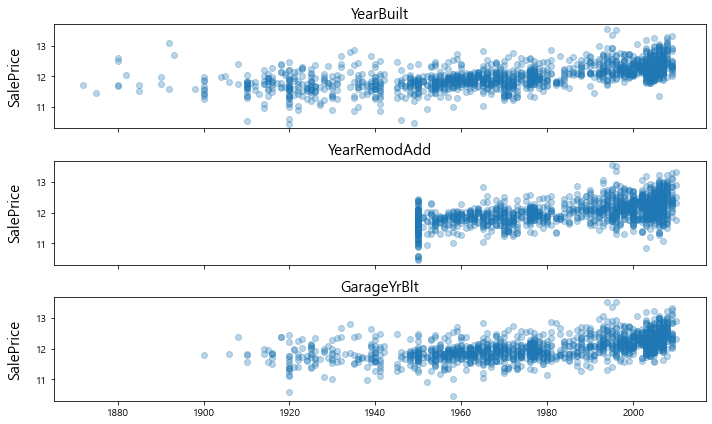

In [27]:
# SalePrice와 연관지어 시각화 구현(로그변환한 SalePrice)
# SalePrice 관련 데이터의 연도별 흐름을 scatter plot으로 시각화 하여 비교

fig, ax = plt.subplots(3, 1, figsize = (10,6), sharex = True, sharey = True)

for i, var in enumerate(year_feature):
    if var !='YrSold':
        ax[i].scatter(train[var], y, alpha = 0.3)
        ax[i].set_title('{}'.format(var), size = 15)
        ax[i].set_ylabel('SalePrice', size = 15, labelpad = 12.5)
        
plt.tight_layout()
plt.show()

- 3개의 변수 모두 SalePrice와 관련된 변수
- 3개의 변수 모두 연도가 지나감에 따라 가격이 우상향함
- 일반적으로 리모델링후에 주택 가격을 높여 판매하고자 하기 때문에 YearRemodAdd 만을 도출 변수에 활용 (나머지 drop)
- 기회가 된다면 나머지 변수들과의 상관관계 파악을 통한 도출 변수 추가를 해도 좋은 도출 변수가 될 것

In [28]:
all_df = all_df.drop(['YearBuilt', 'GarageYrBlt'], axis = 1)
print(all_df.shape)

(2917, 66)


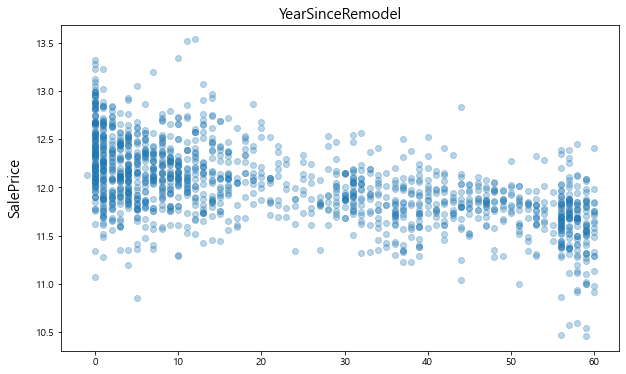

In [29]:
# YrSold 와 YearRemodAdd 두 변수의 연도 차이에 대한 변수 생성 
# 즉, 리모델링 후 몇년 뒤에 판매가 되었는지 확인 가능
YearSinceRemodel = train['YrSold'].astype(int) - train['YearRemodAdd'].astype(int)

# 결과 시각화
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(YearSinceRemodel, y, alpha = 0.3)
ax.set_title('YearSinceRemodel', size = 15)
ax.set_ylabel('SalePrice', size = 15, labelpad = 12.5)
fig.show()

- 도출되는 값이 크면 클수록 SalePrice 값이 하양 하는 모양을 그리고 있다.

In [30]:
# 생성한 데이터 저장 및 drop
all_df['YearSinceRemodel'] = all_df['YrSold'].astype(int) - all_df['YearRemodAdd'].astype(int)

all_df = all_df.drop(['YrSold', 'YearRemodAdd'], axis = 1)
print(all_df.shape)

(2917, 65)


### 더미변수 만들기

- 범주형 변수를 수치형으로 바꾸는 방법(통계학적 의미)
    - '남', '여' 로만 구성된 변수를 남 = 1, 여 = 0 으로 치환하는 것
- 반대로 데이터의 범위가 매우 좁은 수치형 변수를 범주형 변수화 할 수 도 있다.

In [31]:
# 수치형 변수인 
all_df['PoolArea'].value_counts()

0.00    2904
5.84       1
6.05       1
5.95       1
5.91       1
5.79       1
5.85       1
6.16       1
4.72       1
5.55       1
5.72       1
5.13       1
5.92       1
6.23       1
Name: PoolArea, dtype: int64

- 대부분의 값이 0이고, 나머지는 소수점인 값을 각 1개씩 갖고 있다.
- 이 경우 소수인 변수들을 삭제하는 것도 하나의 방법
- 또는, 1이상이면 1로 변환하여 0 과 1로 범주형 변수로 만들어 주는 것도 방법이다.

In [33]:
# 1을 기준으로 0과 1로 범주화 해주는 함수 생성
def count_dummy(x):
    if x > 0:
        return 1
    else:
        return 0

# PoolArea 변수에 적용
all_df['PoolArea'] = all_df['PoolArea'].apply(count_dummy)
all_df['PoolArea'].value_counts()

0    2904
1      13
Name: PoolArea, dtype: int64

In [34]:
# GarageArea 변수에 적용
all_df['GarageArea'] = all_df['GarageArea'].apply(count_dummy)
all_df['GarageArea'].value_counts()

1    2760
0     157
Name: GarageArea, dtype: int64

In [35]:
# GarageArea 변수에 적용
all_df['Fireplaces'] = all_df['Fireplaces'].apply(count_dummy)
all_df['Fireplaces'].value_counts()

1    1497
0    1420
Name: Fireplaces, dtype: int64

#### Label Encoding, Ordinal Encoding, One-Hot Encoding

![image](https://user-images.githubusercontent.com/74717033/132212066-4a82f971-6993-4fe9-be40-19cfdb3381fc.png)

- 독립변수에 적용되는 OneHotEncoder와 OrdinalEncoder 중 어떤 것을 사용할지는 데이터 타입의 유형에 따라 다르다.
- 추가적인 전처리도 필요할 수 있다.

- 값이 3개 이상인 범주형 변수일때 사용되는 방법들
- Label Encoding : 문자열 데이터를 각 범주의 개수에 따라 숫자로 변환하는 방식
- One_Hot Encoding : 각 값을 변수로 변환하여 각각 0과 1로 변환

In [37]:
# Label Endocer 예시
from sklearn.preprocessing import LabelEncoder

temp = pd.DataFrame({'Food_Name': ['Apple', 'Chicken', 'Broccoli'],
                    'Calories':[95,231,50]})

encoder = LabelEncoder()
encoder.fit(temp['Food_Name'])
labels = encoder.transform(temp['Food_Name'])
print(list(temp['Food_Name']), "==>", labels)

['Apple', 'Chicken', 'Broccoli'] ==> [0 2 1]


In [43]:
# Ordinal Encoder 예시

from sklearn.preprocessing import OrdinalEncoder

temp = pd.DataFrame({'Food_Name': ['Apple', 'Chicken', 'Broccoli'],
                    'Calories':[95,231,50]})

encoder = OrdinalEncoder()
labels = encoder.fit_transform(temp[['Food_Name']])
print(list(temp['Food_Name']), "==>", labels.tolist())

['Apple', 'Chicken', 'Broccoli'] ==> [[0.0], [2.0], [1.0]]


- LabelEncoder와 다르게 입력 형태를 '배열' 로 해줘야 한다.
- return되는 값은 정수형이 아니라 실수형으로 출력된다.

In [57]:
# One-Hot Encoding 예시

temp = pd.DataFrame({'Food_Name': ['Apple', 'Chicken', 'Broccoli'],
                    'Calories':[95,231,50]})

temp = pd.get_dummies(temp)

print(temp.shape)
temp

(3, 4)


,Calories,Food_Name_Apple,Food_Name_Broccoli,Food_Name_Chicken
0,95,1,0,0
1,231,0,0,1
2,50,0,1,0


- 서열 척도(e.g: 등급)의 경우 OneHot Encoding을 하는 것이 좋다.
    - 구간에 따라 데이터에 의미가 있기 때문
- 문제는 서열 척도라도 데이터가 스스로 그것을 서열 척도라고 인식하지 못한다.
- Ordinalencoder를 사용해도 수치형으로 변하는 규칙은 그저 A ~ Z 순으로 바뀌기 때문에 서열척도를 인지시키지 못하는 것은 동일
- 이를 Pandas의 replace를 이용해 연구자가 임의로 서열 척도를 인지하도록 코딩할 수도 있다.

In [55]:
temp = pd.DataFrame({'Food_Name': ['Apple', 'Chicken', 'Broccoli'],
                    'Calories':[95, 231, 50]})

# 음식의 중요도에 따라 숫자의 크기를 다르게 변형
temp['Food_No'] = temp.Food_Name.replace(to_replace = ['Chicken','Broccoli','Apple'], 
                                          value = [1, 2, 3] )

print(temp)

  Food_Name  Calories  Food_No
0     Apple        95        3
1   Chicken       231        1
2  Broccoli        50        2


- 명목척도를 이런 ordinalencoder() 방식처럼 처리하면 (남자 1, 여자 0) 이는 남자가 여자보다 더 중요하다고 인식한다. (vice versa)
- 즉, 각 구간의 값 자체에는 차이가 없지만 ordinalencoder()로 처리할 경우 모델이 두 데이터에 서로 차이가 있는 것으로 인식하게 된다.
- 이 경우는 One-Hot encoding을 하는 것이 더 합리적이다.
- 하지만 One-Hot encoding은 범주형 변수의 범주값이 여러개인 경우 사용하기 어렵다.
    - 만약 범주형 변수의 shape가 (10000 , 5000) 이라면?
    - 5000 개의 변수가 추가 된다 = 차원의 저주 문제 발생
    - 이러한 경우는 사전 전처리를 통해 5000개의 범주를 적당한 숫자로 줄이는 것이 좋다.
    - 이는 정해진 방법이 있는 것이 아니므로, 연구자가 임의로 조정할 수 있다.
    - 가장 대표적인 방식은 전체 적인 비율을 기반으로 불필요한 변수들은 'Others'로 모으고, 나머지 범주들로 변수의 수를 줄이는 것이다.

#### all_df에 One-Hot encoding  적용하기

In [58]:
all_df = pd.get_dummies(all_df).reset_index(drop=True)
all_df.shape

(2917, 65)

# Modeling